# Yolo Small Model with img_size = 640

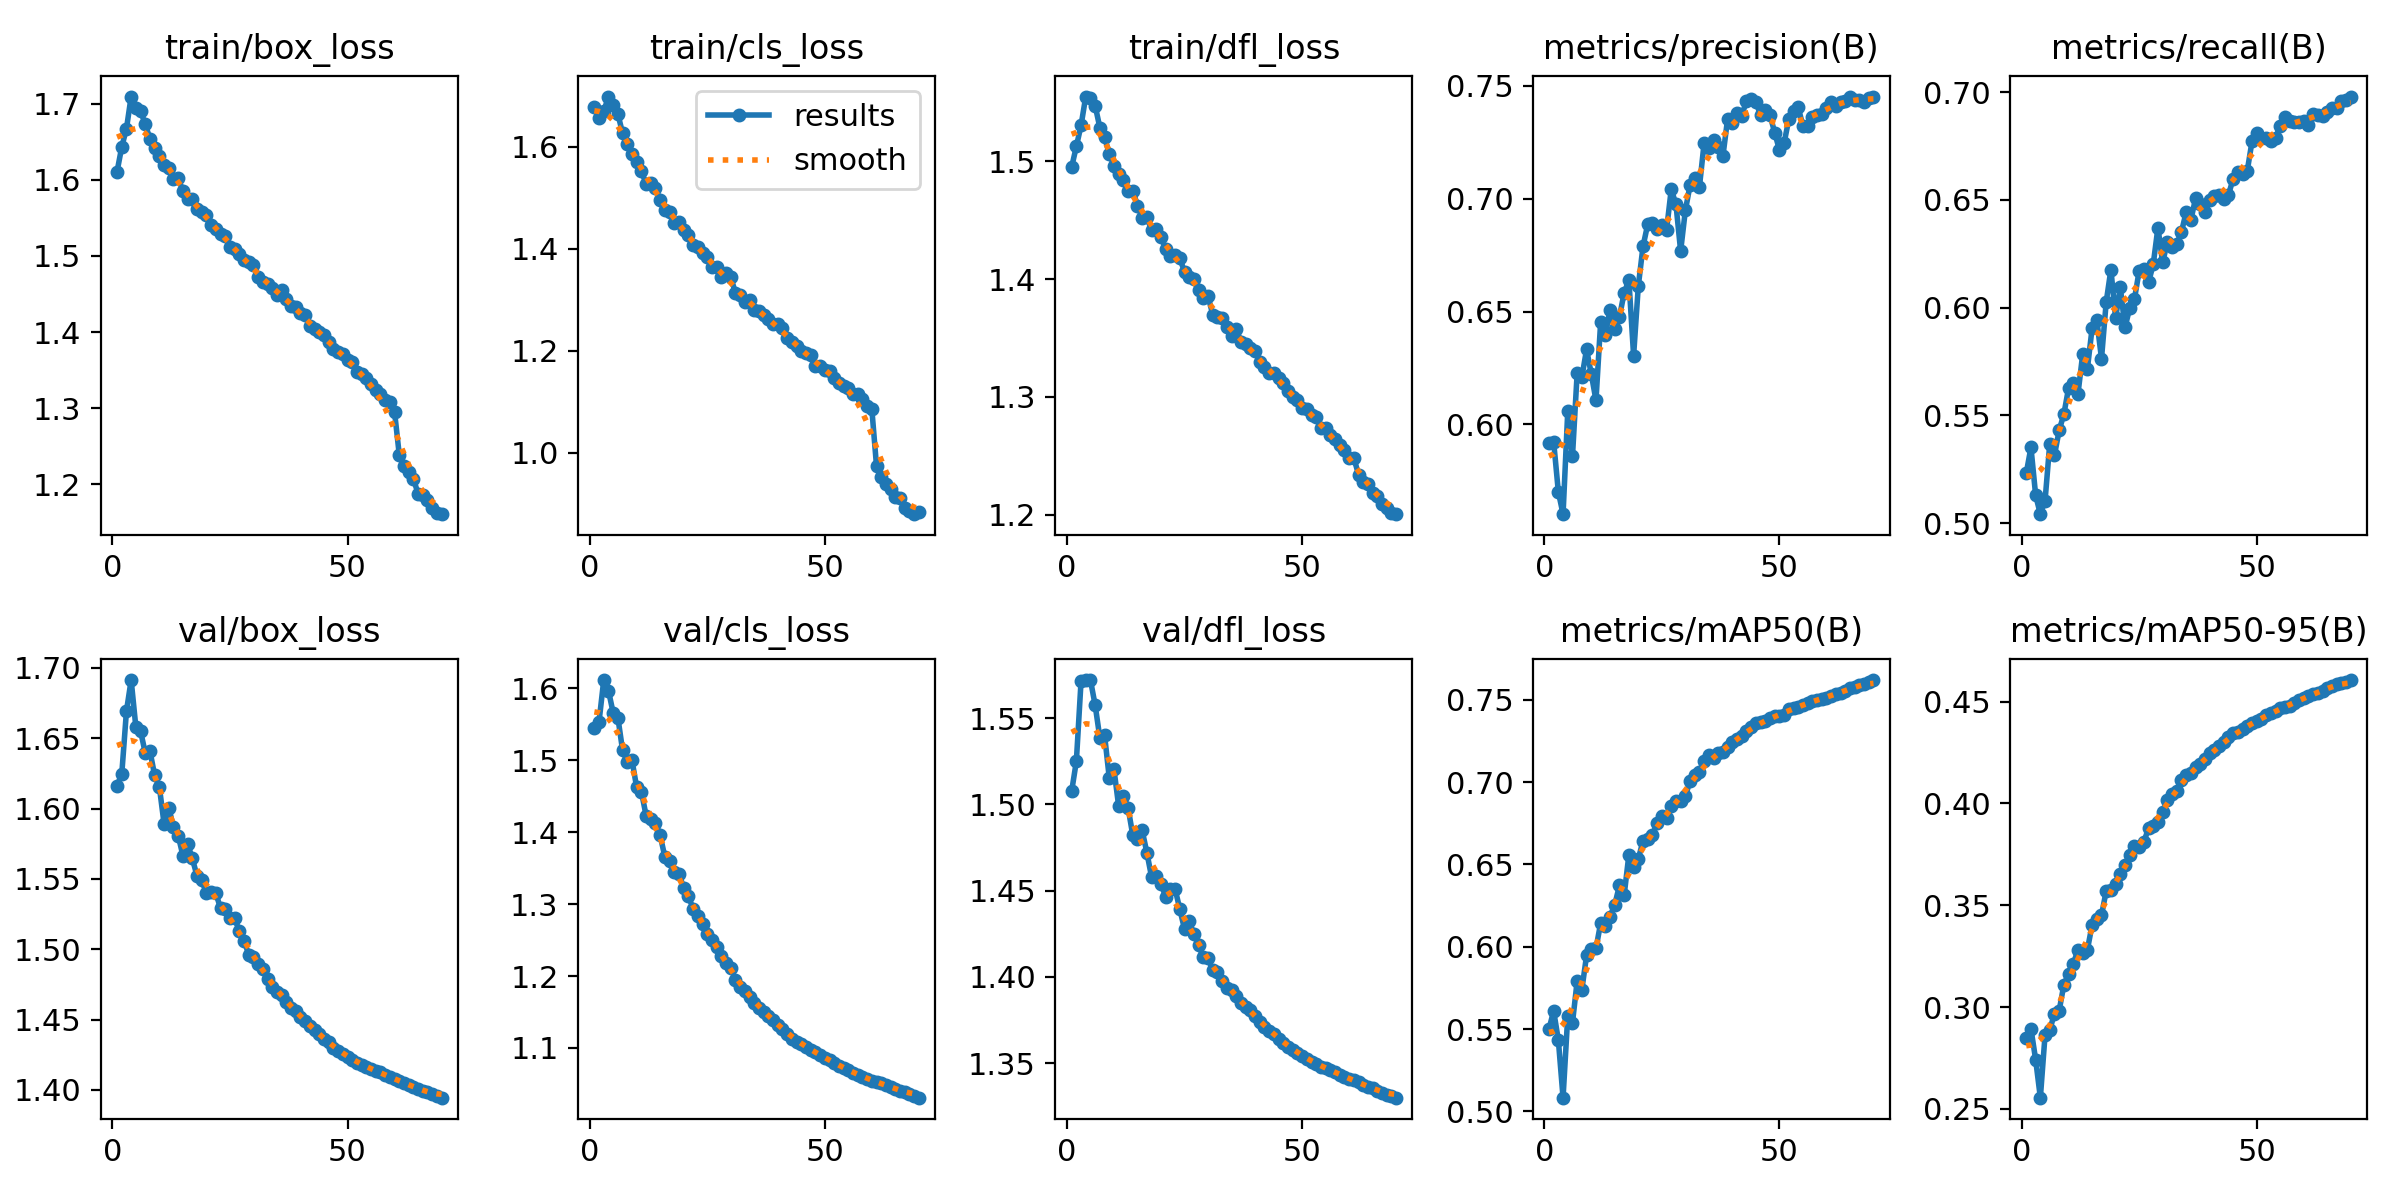

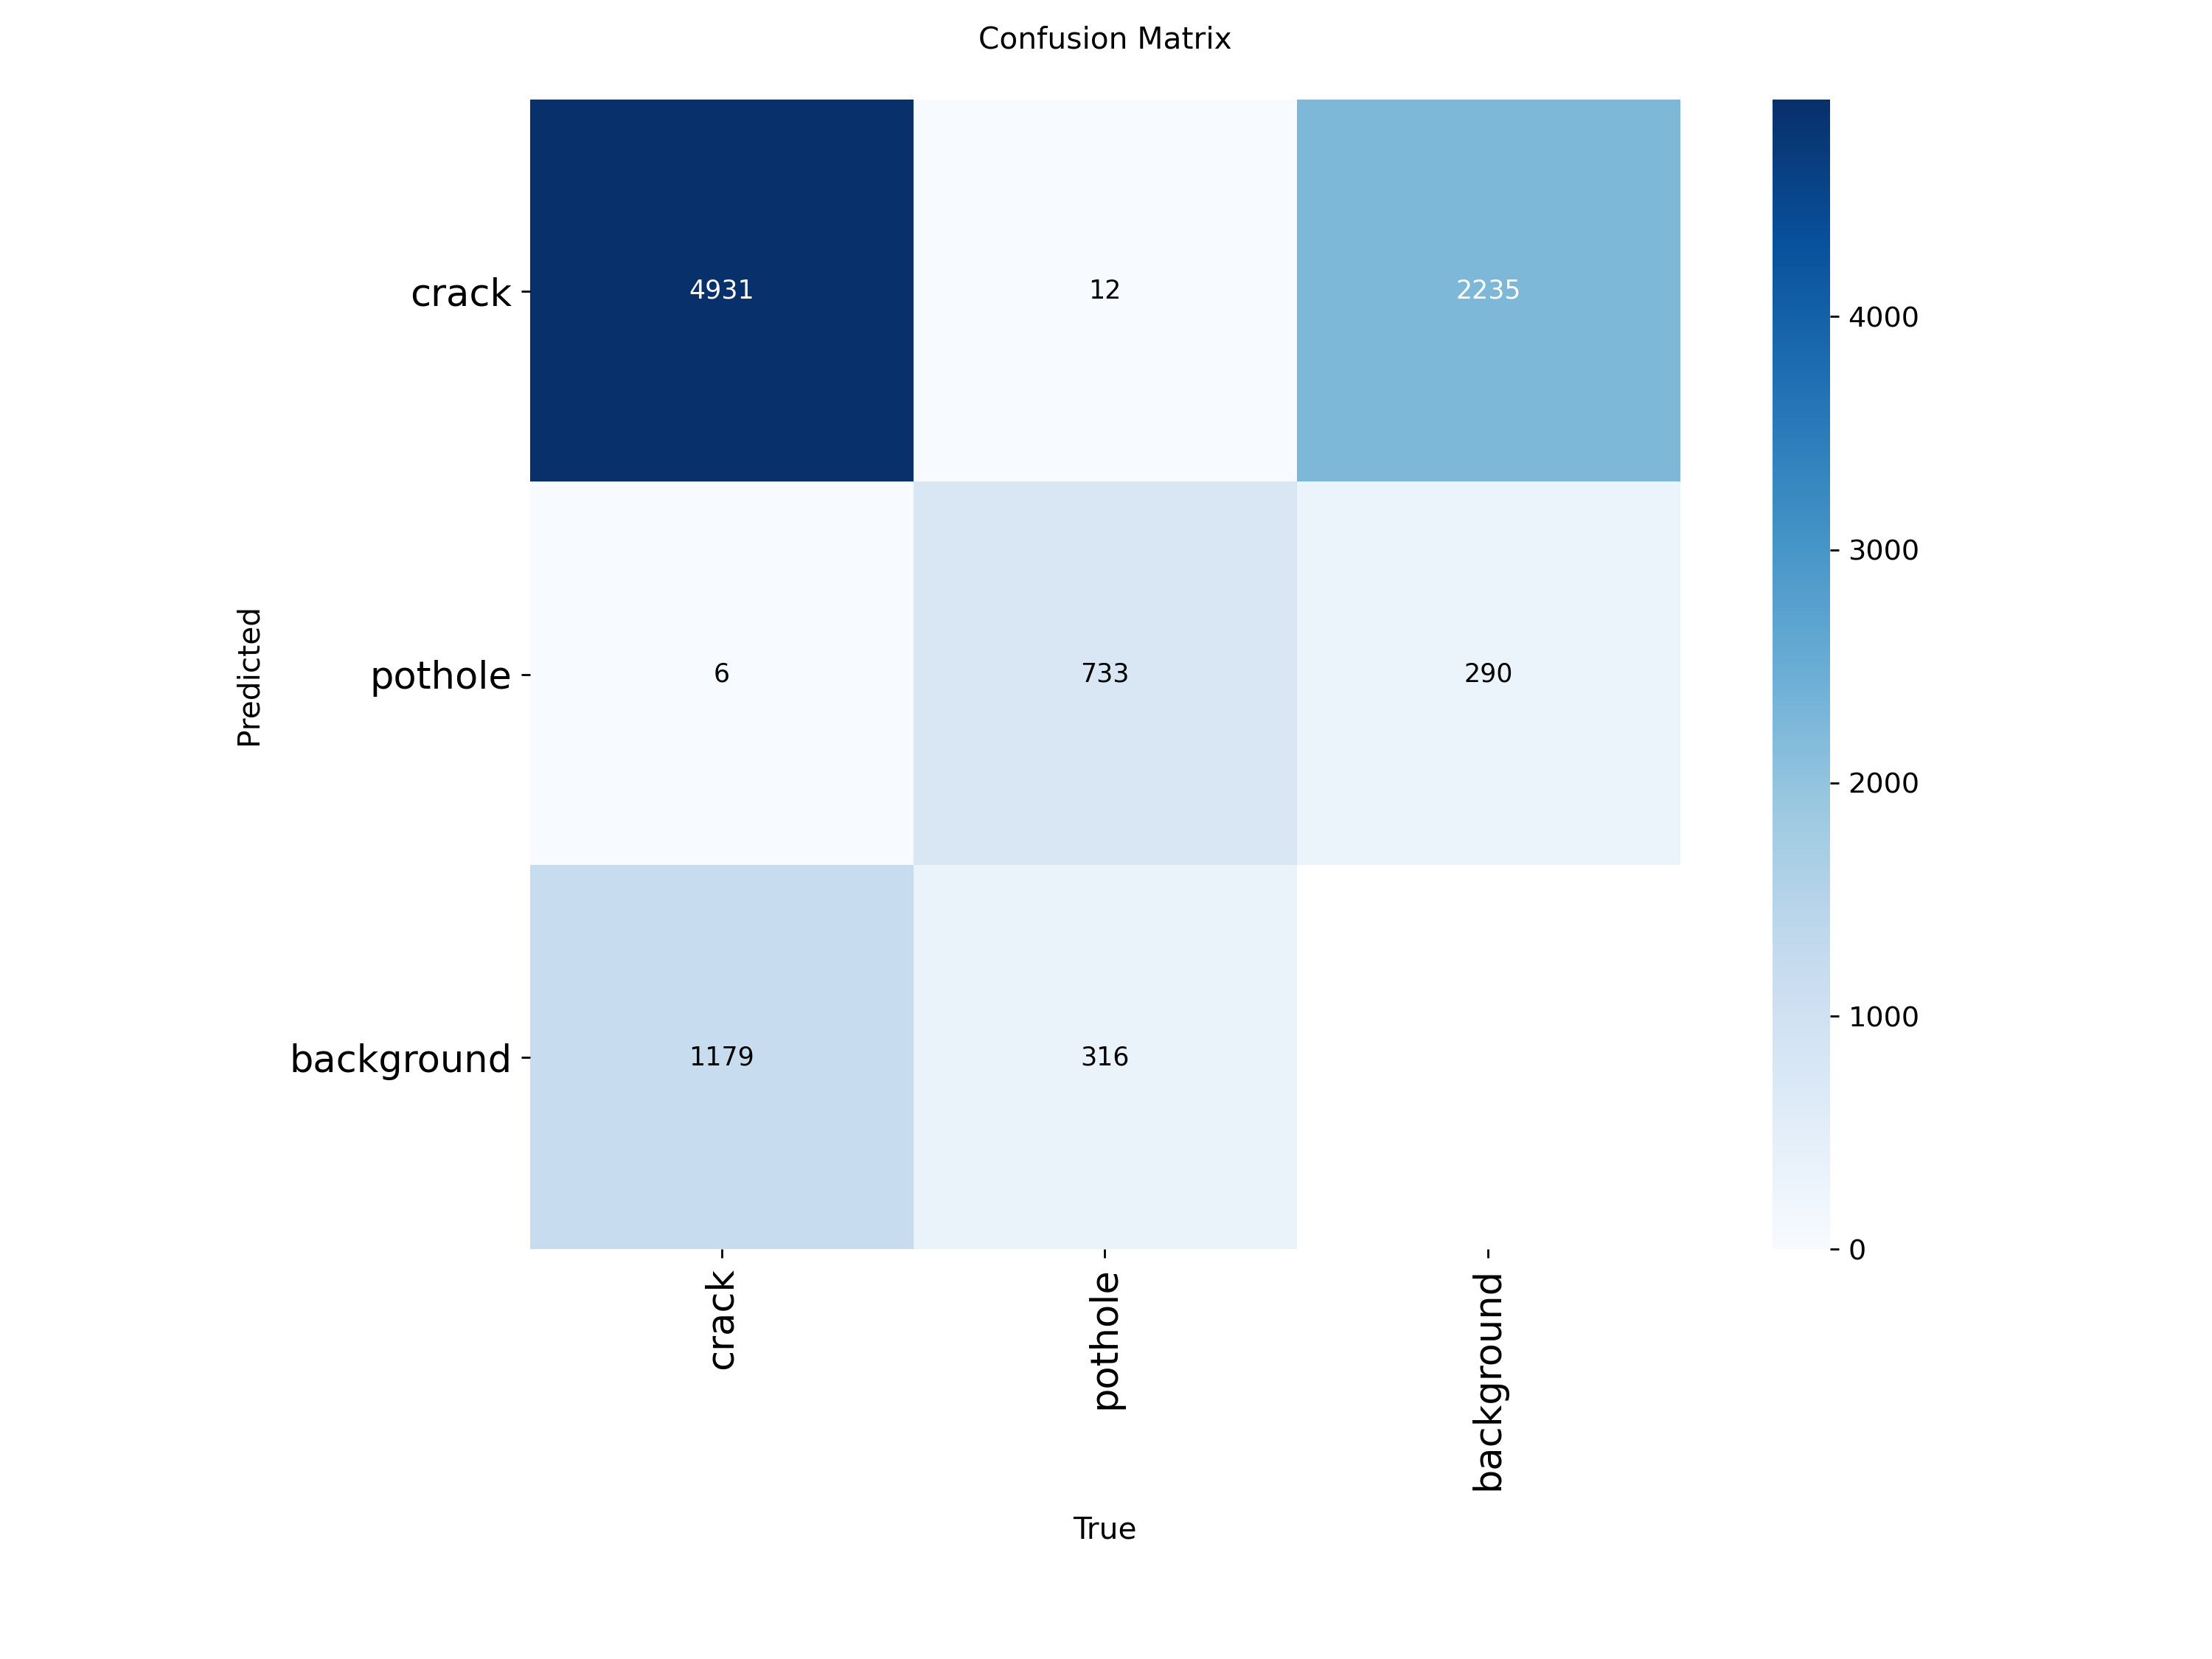

In [1]:
from IPython.display import Image, display
from pathlib import Path

RUN_DIR = Path("../../../runs/detect/yolov8s_rdd2022_2class7")

display(Image(filename=str(RUN_DIR / "results.png")))
display(Image(filename=str(RUN_DIR / "confusion_matrix.png")))


In [2]:
import pandas as pd

results_csv = RUN_DIR / "results.csv"
assert results_csv.exists(), "results.csv not found!"

df = pd.read_csv(results_csv)
df.tail()

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2,lr/pg3,lr/pg4,lr/pg5,lr/pg6,lr/pg7
65,66,12108.5,1.18535,0.91195,1.21542,0.74361,0.69247,0.75794,0.45779,1.39958,1.04084,1.33409,0.002421,0.000807,0.002421,0.000807,0.002421,0.000807,0.002421,0.000807
66,67,12289.9,1.17909,0.89206,1.20933,0.74380,0.69269,0.75884,0.45883,1.39827,1.03831,1.33283,0.001997,0.000666,0.001997,0.000666,0.001997,0.000666,0.001997,0.000666
67,68,12470.9,1.16900,0.88675,1.20518,0.74305,0.69563,0.75986,0.45901,1.39696,1.03582,1.33174,0.001573,0.000524,0.001573,0.000524,0.001573,0.000524,0.001573,0.000524
68,69,12652.0,1.16216,0.87994,1.20153,0.74461,0.69614,0.76101,0.45975,1.39556,1.03353,1.33080,0.001149,0.000383,0.001149,0.000383,0.001149,0.000383,0.001149,0.000383
69,70,12832.7,1.16082,0.88446,1.20028,0.74527,0.69789,0.76196,0.46057,1.39449,1.03091,1.32993,0.000724,0.000241,0.000724,0.000241,0.000724,0.000241,0.000724,0.000241


In [3]:
final = df.iloc[-1]

print("Final metrics:")
print(f"Precision: {final['metrics/precision(B)']:.4f}")
print(f"Recall:    {final['metrics/recall(B)']:.4f}")
print(f"mAP@0.5:   {final['metrics/mAP50(B)']:.4f}")
print(f"mAP@0.5:0.95: {final['metrics/mAP50-95(B)']:.4f}")

Final metrics:
Precision: 0.7453
Recall:    0.6979
mAP@0.5:   0.7620
mAP@0.5:0.95: 0.4606


In [4]:
# F1 Score Calculation
precision = final['metrics/precision(B)']
recall = final['metrics/recall(B)']
if precision + recall > 0:
    f1_score = 2 * (precision * recall) / (precision + recall)
else:
    f1_score = 0.0
print(f"F1 Score: {f1_score:.4f}")

F1 Score: 0.7208


# Inference on Video

In [27]:
from pathlib import Path
from ultralytics import YOLO

# ================= CONFIG =================
VIDEO_PATH = Path("../../../data/videos/3695999-hd_1920_1080_24fps.mp4")
MODEL_PATH = "../../../runs/detect/yolov8s_rdd2022_2class7/weights/best.pt"

OUTPUT_ROOT = Path("/home/saber/GitHub/road_anomaly_detection/runs/rdd2022_finetuned/video_outputs")

IMG_SIZE = 640
CONF = 0.25
IOU = 0.7
DEVICE = 0
# =========================================

print(f"▶ Testing video: {VIDEO_PATH.name}")

OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)

model = YOLO(MODEL_PATH)

# ✅ Correct YOLO video inference
model.predict(
    source=str(VIDEO_PATH),
    imgsz=IMG_SIZE,
    conf=CONF,
    iou=IOU,
    device=DEVICE,
    save=True,
    project=str(OUTPUT_ROOT),
    name=VIDEO_PATH.stem,
    verbose=True
)

# -------- VERIFY (robust) --------
out_dir = OUTPUT_ROOT / VIDEO_PATH.stem
videos = list(out_dir.glob("*.mp4")) + list(out_dir.glob("*.avi"))

print("\n--- RESULT ---")
print("Output directory:", out_dir)
print("Videos found:", videos)

if videos:
    print("🎥 Annotated video saved at:", videos[0])
else:
    print("❌ No video file found")

▶ Testing video: 3695999-hd_1920_1080_24fps.mp4

WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/1056) /home/saber/GitHub/road_anomaly_detection/src/fine_tuning/rd22/../../../data/videos/3695999-hd_1920_1080_24fps.mp4: 384x640 (no detections), 4.2ms
video 1/1 (frame 2/1056) /home/saber/GitHub/road_anomaly_detection/src/fine_tuning/rd22/../../../data/videos/3695999-hd_1920_1080_24fps.mp4: 384x640 (no detections), 3.9ms
video 1/1 (frame 3/1056) /home/saber/GitHub/road_anomaly_detection

# Average FPS on GPU

In [1]:
from pathlib import Path
from ultralytics import YOLO
import time
import cv2

# ================= CONFIG =================
VIDEO_PATH = Path("../../../data/videos/3695999-hd_1920_1080_24fps.mp4")
MODEL_PATH = "../../../runs/detect/yolov8s_rdd2022_2class7/weights/best.pt"

OUTPUT_ROOT = Path("/home/saber/GitHub/road_anomaly_detection/runs/rdd2022_finetuned/video_outputs")

IMG_SIZE = 640
CONF = 0.25
IOU = 0.7
DEVICE = 0
# =========================================

print(f"▶ Testing video: {VIDEO_PATH.name}")

OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)

# -------- Load model --------
model = YOLO(MODEL_PATH)

# -------- Get frame count from video --------
cap = cv2.VideoCapture(str(VIDEO_PATH))
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.release()

print(f"📸 Total frames in video: {frame_count}")

# -------- Run inference & time it --------
start_time = time.perf_counter()

model.predict(
    source=str(VIDEO_PATH),
    imgsz=IMG_SIZE,
    conf=CONF,
    iou=IOU,
    device=DEVICE,
    save=True,
    project=str(OUTPUT_ROOT),
    name=VIDEO_PATH.stem,
    verbose=True
)

end_time = time.perf_counter()

# -------- FPS calculation --------
elapsed_time = end_time - start_time
avg_fps = frame_count / elapsed_time if elapsed_time > 0 else 0.0

# -------- VERIFY OUTPUT --------
out_dir = OUTPUT_ROOT / VIDEO_PATH.stem
videos = list(out_dir.glob("*.mp4")) + list(out_dir.glob("*.avi"))

print("\n--- RESULT ---")
print("Output directory:", out_dir)
print("Videos found:", videos)

if videos:
    print("🎥 Annotated video saved at:", videos[0])

print("\n--- PERFORMANCE ---")
print(f"⏱ Total inference time: {elapsed_time:.2f} seconds")
print(f"🚀 Average FPS: {avg_fps:.2f}")

▶ Testing video: 3695999-hd_1920_1080_24fps.mp4
📸 Total frames in video: 1056

WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/1056) /home/saber/GitHub/road_anomaly_detection/src/fine_tuning/rd22/../../../data/videos/3695999-hd_1920_1080_24fps.mp4: 384x640 (no detections), 25.6ms
video 1/1 (frame 2/1056) /home/saber/GitHub/road_anomaly_detection/src/fine_tuning/rd22/../../../data/videos/3695999-hd_1920_1080_24fps.mp4: 384x640 (no detections), 3.5ms
video 1/1 (frame 3/1056) /home/sabe

# Average FPS on CPU

In [2]:
from pathlib import Path
from ultralytics import YOLO
import time
import cv2

# ================= CONFIG =================
VIDEO_PATH = Path("../../../data/videos/3695999-hd_1920_1080_24fps.mp4")
MODEL_PATH = "../../../runs/detect/yolov8s_rdd2022_2class7/weights/best.pt"

OUTPUT_ROOT = Path("/home/saber/GitHub/road_anomaly_detection/runs/rdd2022_finetuned/video_outputs")

IMG_SIZE = 640
CONF = 0.25
IOU = 0.7
DEVICE = "cpu"
# =========================================

print(f"▶ Testing video: {VIDEO_PATH.name}")

OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)

# -------- Load model --------
model = YOLO(MODEL_PATH)

# -------- Get frame count from video --------
cap = cv2.VideoCapture(str(VIDEO_PATH))
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.release()

print(f"📸 Total frames in video: {frame_count}")

# -------- Run inference & time it --------
start_time = time.perf_counter()

model.predict(
    source=str(VIDEO_PATH),
    imgsz=IMG_SIZE,
    conf=CONF,
    iou=IOU,
    device=DEVICE,
    save=True,
    project=str(OUTPUT_ROOT),
    name=VIDEO_PATH.stem,
    verbose=True
)

end_time = time.perf_counter()

# -------- FPS calculation --------
elapsed_time = end_time - start_time
avg_fps = frame_count / elapsed_time if elapsed_time > 0 else 0.0

# -------- VERIFY OUTPUT --------
out_dir = OUTPUT_ROOT / VIDEO_PATH.stem
videos = list(out_dir.glob("*.mp4")) + list(out_dir.glob("*.avi"))

print("\n--- RESULT ---")
print("Output directory:", out_dir)
print("Videos found:", videos)

if videos:
    print("🎥 Annotated video saved at:", videos[0])

print("\n--- PERFORMANCE ---")
print(f"⏱ Total inference time: {elapsed_time:.2f} seconds")
print(f"🚀 Average FPS: {avg_fps:.2f}")

▶ Testing video: 3695999-hd_1920_1080_24fps.mp4
📸 Total frames in video: 1056

WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/1056) /home/saber/GitHub/road_anomaly_detection/src/fine_tuning/rd22/../../../data/videos/3695999-hd_1920_1080_24fps.mp4: 384x640 (no detections), 153.6ms
video 1/1 (frame 2/1056) /home/saber/GitHub/road_anomaly_detection/src/fine_tuning/rd22/../../../data/videos/3695999-hd_1920_1080_24fps.mp4: 384x640 (no detections), 65.7ms
video 1/1 (frame 3/1056) /home/sa